## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
%matplotlib inline
import glob

In [2]:
#Options and Settings
warnings.simplefilter('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
colors = sns.color_palette("Set3", 10)

In [56]:
#Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,QuantileTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## Importing Datasets

Data Description
**client_data.csv**

- id = client company identifier
- activity_new = category of the company’s activity
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months

**price_data.csv**

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)


In [4]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



## User Defined Functions

In [5]:
# Function to label partitions of pie chart

def annotation_labeling(lbl,vals):
    absolute = int(np.round(lbl/100.*np.sum(vals)))
    return "{:.1f}%\n({:d})".format(lbl,absolute)

In [6]:
def iqr_range(arr):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr,0.75)
    iqr = q3-q1
    return q1-(iqr*1.5),q3+(iqr*1.5)

In [7]:
def outlier_removal(df,column,drop_percentage=0.05):

    actual_rows = df.shape[0]
    lower_bound,upper_bound = iqr_range(df[column].values)
    outliers = df[ (df[column]<lower_bound) | (df[column] > upper_bound)]
    print('Total No of rows in actual dataframe: ',actual_rows,'\nTotal No of rows in outliers: ',outliers.shape[0])
    if outliers.shape[0] <= round(actual_rows*drop_percentage):
        df.drop(outliers.index,inplace=True)

    return df

## Exploring Price Data

In [8]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [9]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [10]:
#Checking for duplicates

price_data[price_data.duplicated()]

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix


In [11]:
price_data = price_data.astype({'price_date' : 'datetime64[ns]'})

In [12]:
print('No of unique clients: ', price_data.id.nunique())

price_data.describe()

No of unique clients:  16096


,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592


## Merging Client Dataset and Price Dataset
Merging price and client dataset using id

In [13]:
client_churn_info = client_data[['id','churn']]
price_df = client_churn_info.merge(price_data,on='id')

In [14]:
price_df.head()

,id,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


## Univariant Analysis
Plotting histogram to see the distribution of the data

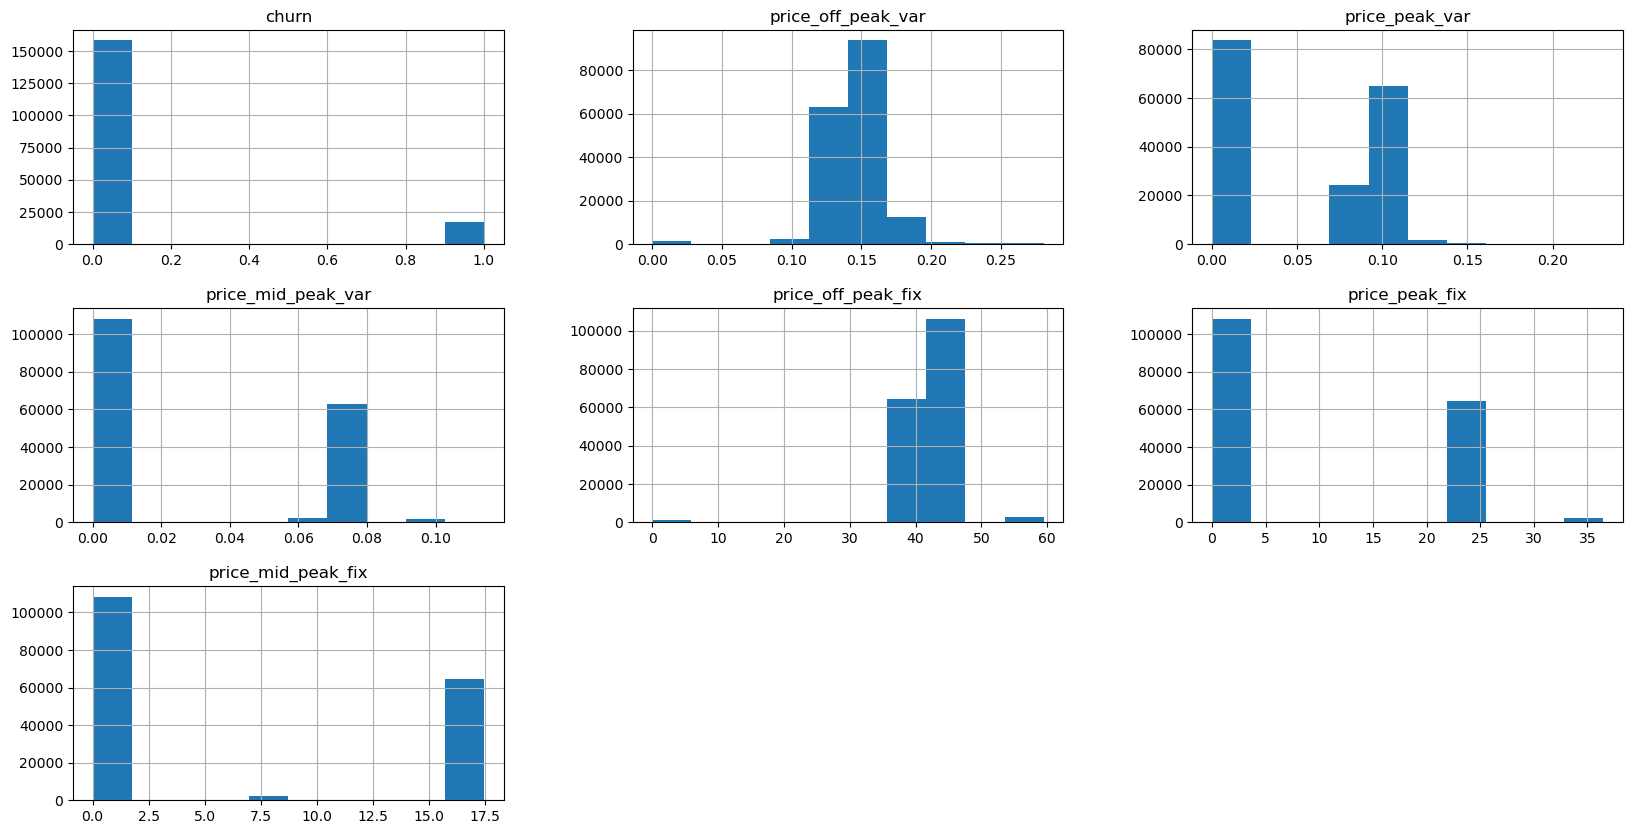

In [15]:
price_df.groupby(['id','price_date']).mean().hist(figsize=(20,10))
plt.show()

*The HistPlot shows that the data is skewed and show be treated before model creation*

## Plotting Energy and Power Prices

In [16]:
#Splitting the dataset into churn and non-churn price by price date

churn_grp_price = price_df[price_df['churn']==1].drop(columns=['id']).groupby(['price_date']).mean()
non_churn_grp_price = price_df[price_df['churn']==0].drop(columns=['id']).groupby(['price_date']).mean()

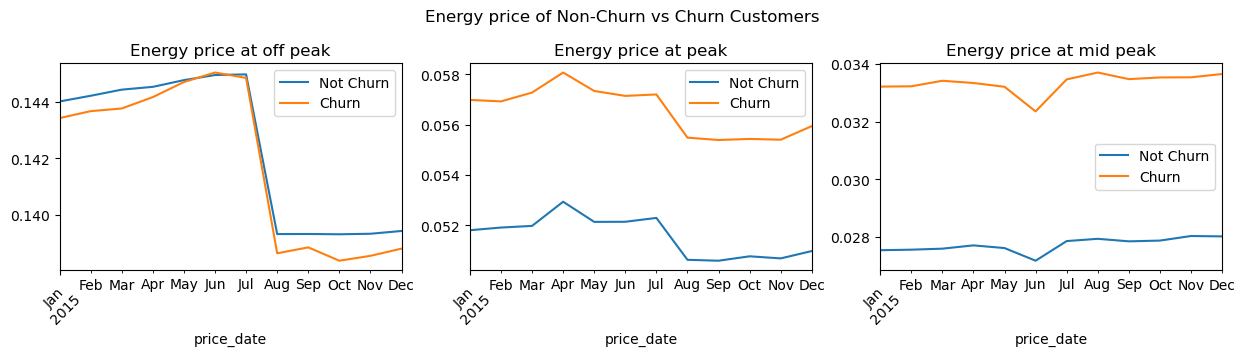

In [17]:
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_var.plot()
churn_grp_price.price_off_peak_var.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_var.plot()
churn_grp_price.price_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_var.plot()
churn_grp_price.price_mid_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Energy price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()

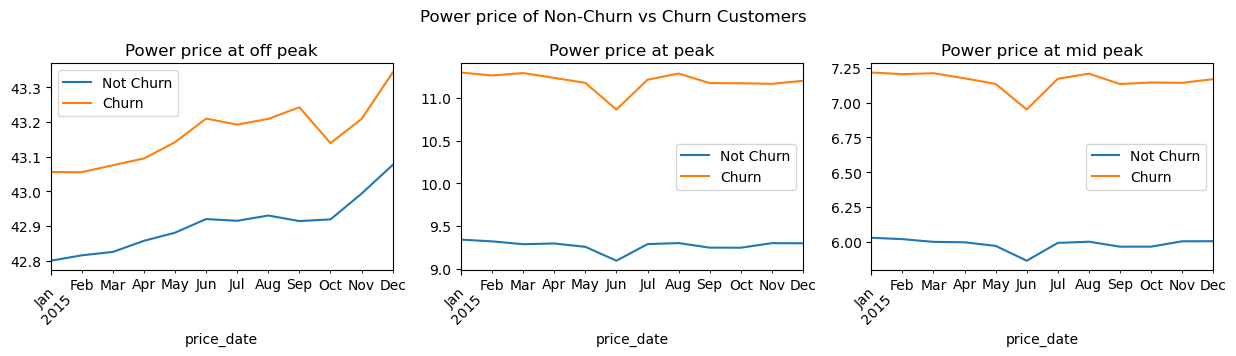

In [18]:
#Plotting average price of power by month
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_fix.plot()
churn_grp_price.price_off_peak_fix.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Power price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_fix.plot()
churn_grp_price.price_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_fix.plot()
churn_grp_price.price_mid_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Power price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()


There is some variation of price between churn and un-churn clients. Churned clients have slightly low off-peak energy prices and high off-peak power prices. But we can't confidently say this is the factor for churn. We need to analyze the data further to arrive at a concrete conclusion.

## Correlational Heatmap
Before merging the dataset with the client dataset, we should conduct a correlation analysis to identify the features replicating the same information.

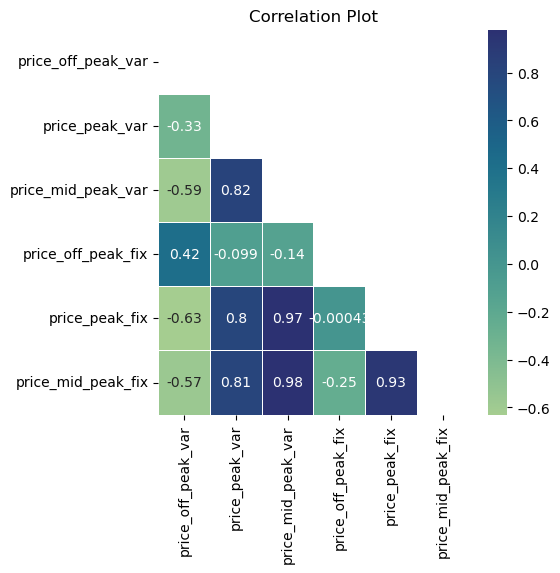

In [19]:
plt.figure(figsize=(5,5))
pd_corr = price_data.drop(columns=['id','price_date']).corr()
mask = np.triu(np.ones_like(pd_corr))
sns.heatmap(pd_corr,annot=True,cmap='crest',linewidths=.5,mask=mask)
plt.title('Correlation Plot')
plt.show()

In [20]:
price_data.drop(['price_peak_var','price_peak_fix','price_mid_peak_var'],axis=1,inplace=True)

High co-relation coefficient values between two features denote high dependency between them. It shows that the two features convey the same information. So one of the features can be dropped.

## Feature Engineering
Since the price information is monthly, we are unable to merge it directly with the client data. Some feature transformations need to be done to derive the yearly prices. The at peak and mid-peak of energy follow a linear flow, so we can take the average of the monthly prices. The eergy off peak price was high at the beginning of the year and low at the end of the year. So we take the price difference as a consolidated value.

In [21]:
#Filter out January and December energy off peak price
price_off_peak_energy = price_data[['id','price_off_peak_var']]
jan_prices = price_off_peak_energy.groupby('id').price_off_peak_var.first().reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_jan'})
dec_prices = price_off_peak_energy.groupby('id').price_off_peak_var.last().reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_dec'})

In [22]:
#Taking average of Power off-peak and mid-peak
price_data.drop('price_off_peak_var',axis=1,inplace=True)
price_data = price_data.groupby('id').mean().reset_index()

In [23]:
#Calculating Energy off peak difference
price_data = price_data.merge(jan_prices,on='id').merge(dec_prices,on='id')
price_data['energy_off_peak_variation'] = price_data.price_off_peak_var_jan - price_data.price_off_peak_var_dec
price_data.drop(['price_off_peak_var_jan','price_off_peak_var_dec'],axis=1,inplace=True)

In [24]:
price_data.head()

,id,price_date,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,0002203ffbb812588b632b9e628cc38d,2015-06-16 12:00:00,40.701732,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,2015-06-16 12:00:00,44.385450,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-06-16 12:00:00,45.319710,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,2015-06-16 12:00:00,40.647427,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,2015-06-16 12:00:00,44.266930,0.000000,0.003994


## Exploring Client Data

In [25]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [26]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [27]:
#Checking for duplicates
client_data[client_data.duplicated()]

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn


In [28]:
client_data = client_data.astype({
    'date_activ' : 'datetime64[ns]',
    'date_end' : 'datetime64[ns]',
    'date_modif_prod' : 'datetime64[ns]',
    'date_renewal' : 'datetime64[ns]'
})

### Data Cleaning and Feature Engineering

In [29]:
#Changing hashed values to meaningful labels for easy understanding
print('Unique Sales Channels :\n',client_data.channel_sales.unique())
print('\nUnique Origin :\n',client_data.origin_up.unique())

Unique Sales Channels :
 ['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa']

Unique Origin :
 ['lxidpiddsbxsbosboudacockeimpuepw' 'kamkkxfxxuwbdslkwifmmcsiusiuosws'
 'ldkssxwpmemidmecebumciepifcamkci' 'MISSING'
 'usapbepcfoloekilkwsdiboslwaxobdp' 'ewxeelcelemmiwuafmddpobolfuxioce']


In [30]:
channel_mask = {
    'MISSING':'missing_data',
    'foosdfpfkusacimwkcsosbicdxkicaua':'channel_1',
    'lmkebamcaaclubfxadlmueccxoimlema':'channel_2',
    'usilxuppasemubllopkaafesmlibmsdf':'channel_3',
    'ewpakwlliwisiwduibdlfmalxowmwpci':'channel_4',
    'epumfxlbckeskwekxbiuasklxalciiuu':'channel_5',
    'sddiedcslfslkckwlfkdpoeeailfpeds':'channel_6',
    'fixdbufsefwooaasfcxdxadsiekoceaa':'channel_7',
}
origin_mask = {
    'lxidpiddsbxsbosboudacockeimpuepw' : 'origin_1',
    'kamkkxfxxuwbdslkwifmmcsiusiuosws' : 'origin_2',
    'ldkssxwpmemidmecebumciepifcamkci' : 'origin_3',
    'usapbepcfoloekilkwsdiboslwaxobdp' : 'origin_4',
    'ewxeelcelemmiwuafmddpobolfuxioce' : 'origin_5',
    'MISSING' : 'origin_missing'
}
client_data.replace({
    'has_gas' : {
        't':1,'f':0
    },
    'channel_sales':channel_mask,
    'origin_up':origin_mask,
},inplace=True)
#Labeled Data
client_data.head()


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,channel_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,origin_1,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,missing_data,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,origin_2,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,channel_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,origin_2,13.856,0
3,bba03439a292a1e166f80264c16191cb,channel_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,origin_2,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,missing_data,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,origin_2,19.800,0


In [31]:
#contract_modification_interval : no of years in which the client last modified their contract.
#contract_interval : no of years client travelled with us.
client_data['contract_modification_interval'] = client_data.date_modif_prod.dt.year - client_data.date_activ.dt.year
client_data['contract_interval'] = client_data.date_end.dt.year - client_data.date_activ.dt.year

### Merging Client and Price Data

In [32]:
df = client_data.merge(price_data,on='id')
print('Total No of Clients in Price Dataset : ',price_data.id.nunique(),'\nTotal No of Clients in Client Dataset : ',client_data.id.nunique(),
      '\nTotal No of Clients after merging : ', df.id.nunique()) 

Total No of Clients in Price Dataset :  16096 
Total No of Clients in Client Dataset :  14606 
Total No of Clients after merging :  14606


In [33]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_modification_interval,contract_interval,price_date,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,24011ae4ebbe3035111d65fa7c15bc57,channel_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,origin_1,43.648,1,2,3,2015-06-16 12:00:00,40.942265,14.901340,-0.020057
1,d29c2c54acc38ff3c0614d0a653813dd,missing_data,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,origin_2,13.800,0,0,7,2015-06-16 12:00:00,44.311375,0.000000,0.003767
2,764c75f661154dac3a6c254cd082ea7d,channel_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,origin_2,13.856,0,0,6,2015-06-16 12:00:00,44.385450,0.000000,0.004670
3,bba03439a292a1e166f80264c16191cb,channel_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,origin_2,13.200,0,0,6,2015-06-16 12:00:00,44.400265,0.000000,0.004547
4,149d57cf92fc41cf94415803a877cb4b,missing_data,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,origin_2,19.800,0,0,6,2015-06-16 12:00:00,40.688156,16.275263,0.006192


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

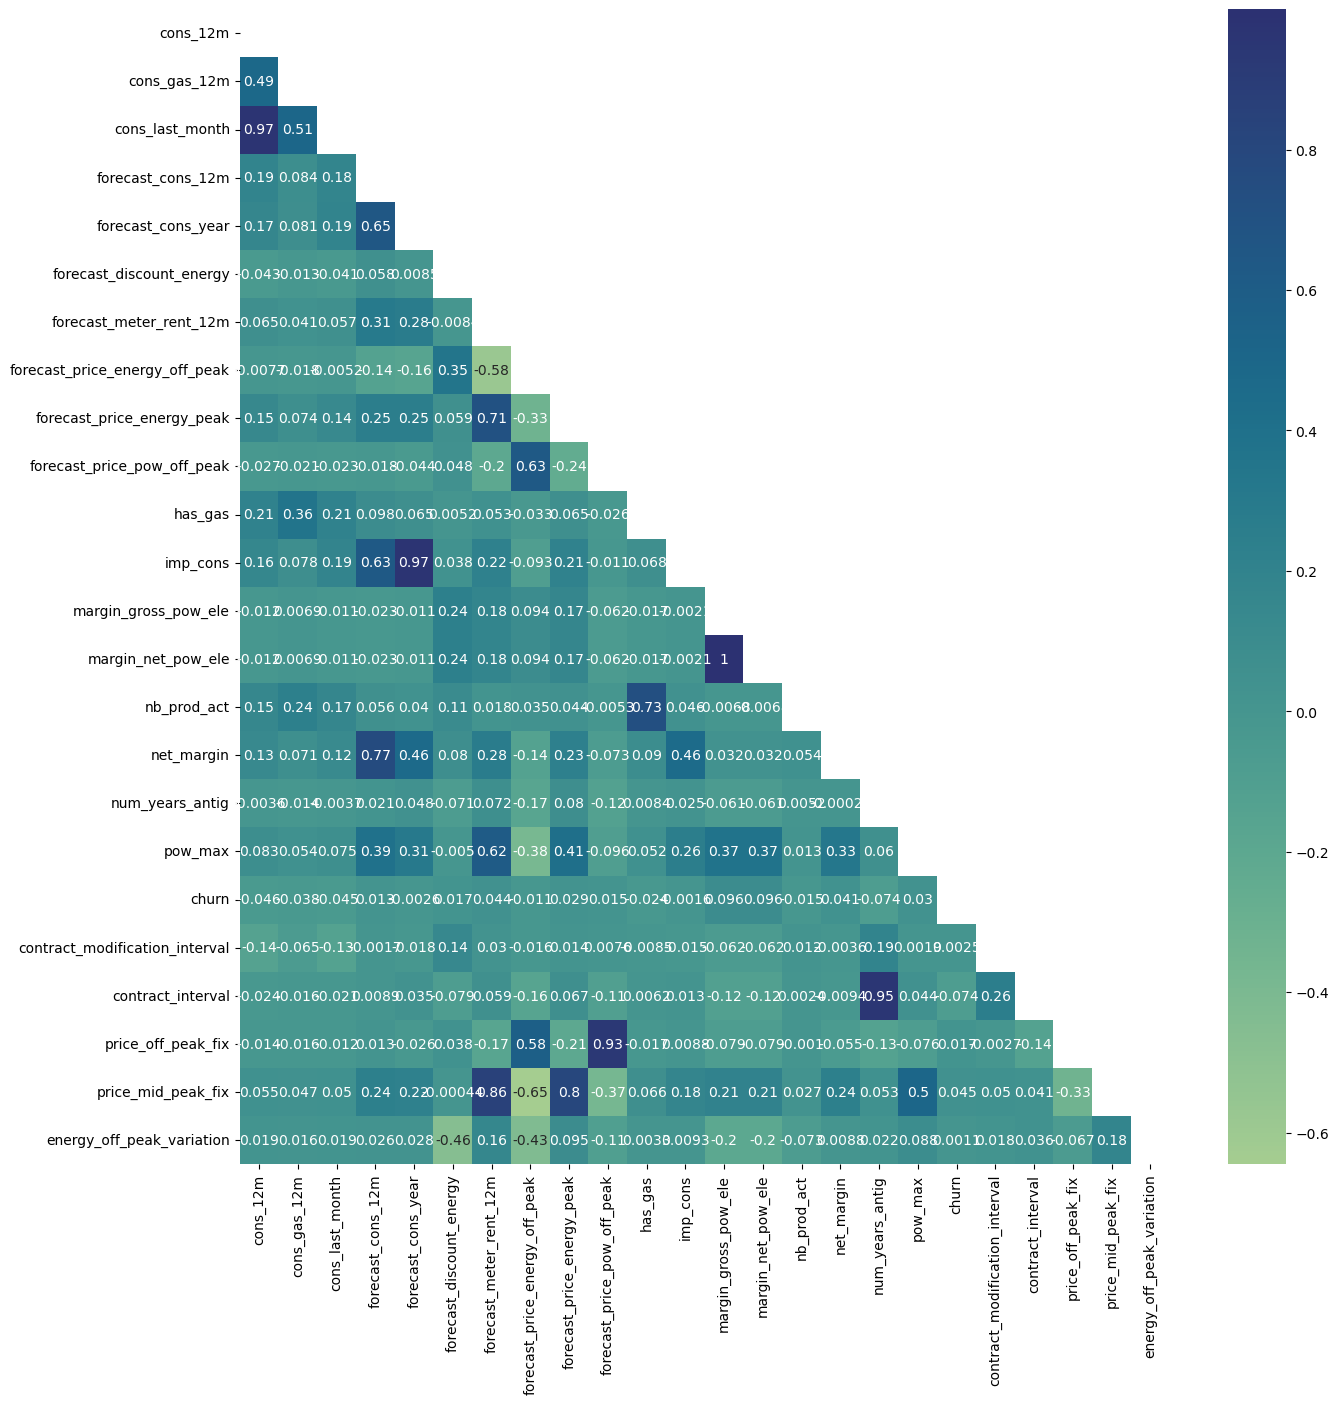

In [35]:
numerics = ['int16','int32','int64','float16','float32','float64']

plt.figure(figsize=(15,15))
df_corr = df.select_dtypes(include=numerics).corr()
mask = np.triu(np.ones_like(df_corr))
sns.heatmap(df_corr,annot=True,cmap='crest',mask=mask)
plt.show()

In [36]:
df.drop([
    #Highly correlated columns
    'cons_last_month','forecast_cons_12m', 'forecast_cons_year','forecast_meter_rent_12m',
    'forecast_meter_rent_12m', 'forecast_price_energy_off_peak','forecast_price_energy_peak', 
    'forecast_price_pow_off_peak','margin_gross_pow_ele', 'nb_prod_act',
    'num_years_antig',
    #Unwanted Columns
    'id','date_activ','date_end','date_renewal','date_modif_prod',
],axis=1,inplace=True)

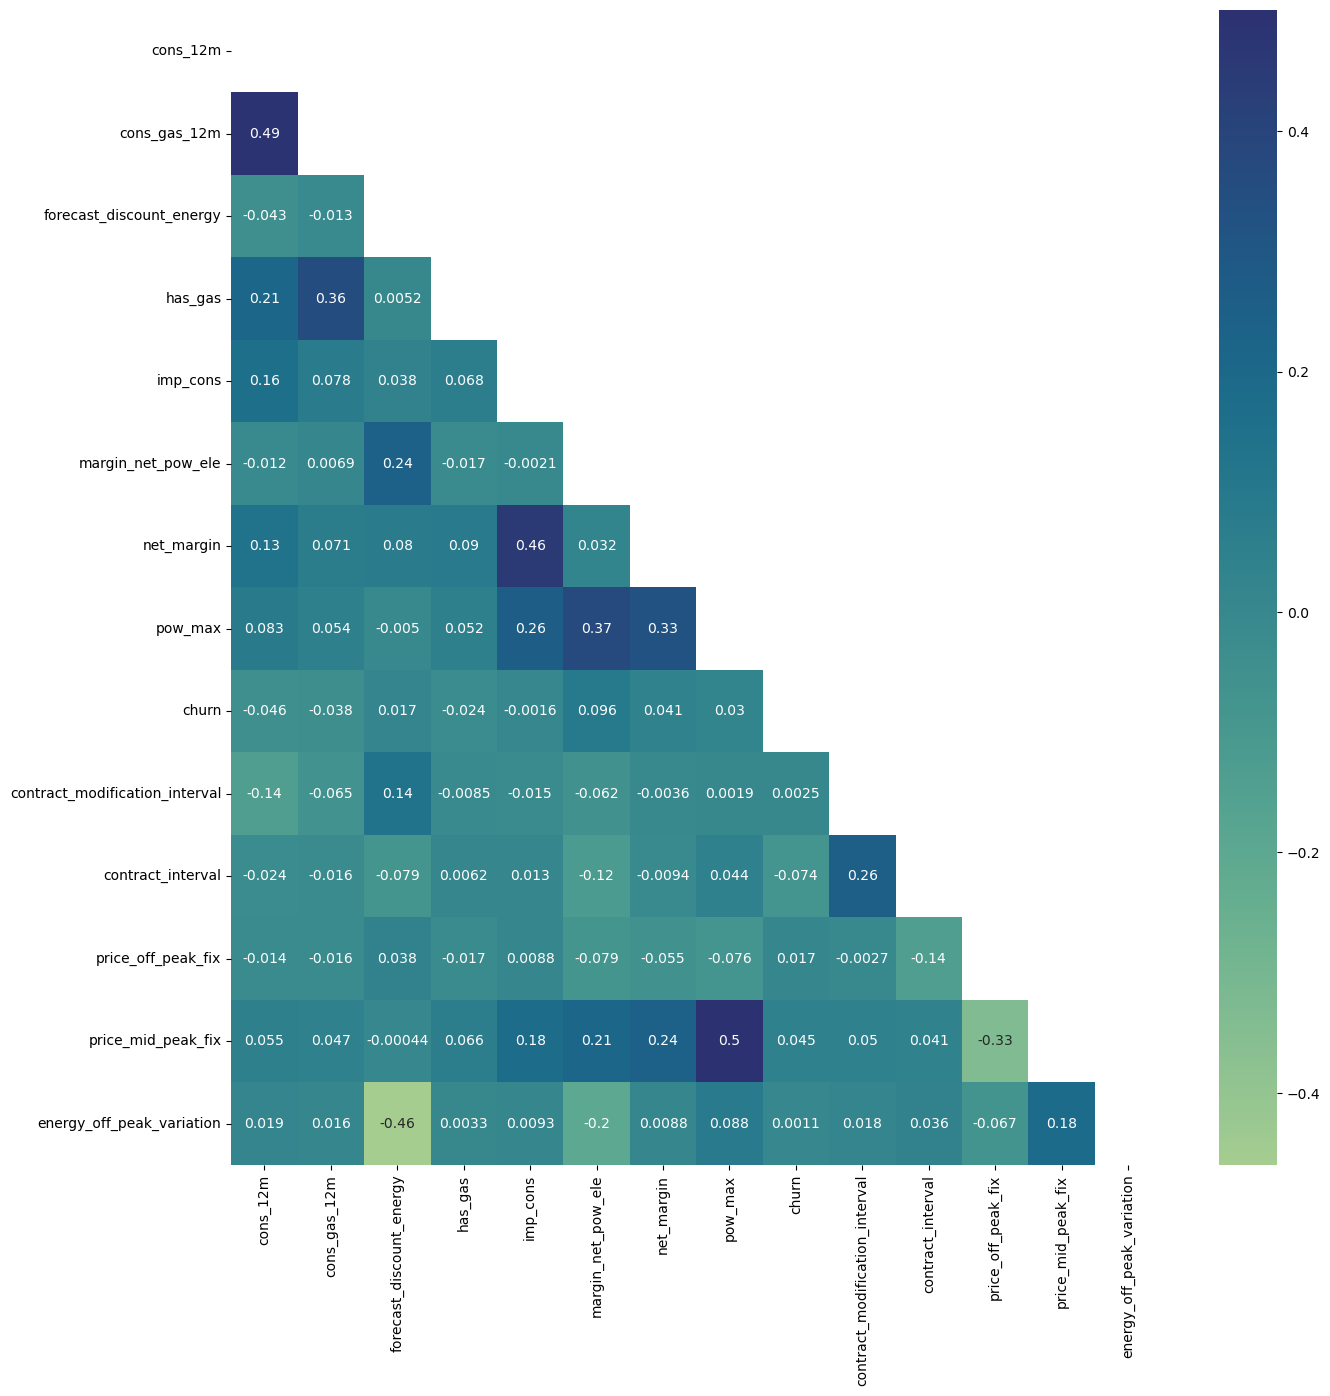

In [37]:
plt.figure(figsize=(15,15))
df_corr = df.select_dtypes(include=numerics).corr()
mask = np.triu(np.ones_like(df_corr))
sns.heatmap(df_corr,annot=True,cmap='crest',mask=mask)
plt.show()

In [38]:
df.describe()

,cons_12m,cons_gas_12m,forecast_discount_energy,has_gas,imp_cons,margin_net_pow_ele,net_margin,pow_max,churn,contract_modification_interval,contract_interval,price_date,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,0.966726,0.181501,152.786896,24.562517,189.264522,18.135136,0.097152,1.890251,5.487060,2015-06-16 12:55:46.613578240,42.928890,6.097680,0.004566
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,3.300000,0.000000,0.000000,2.000000,2015-05-17 00:00:00,0.000000,0.000000,-0.168958
25%,5.674750e+03,0.000000e+00,0.000000,0.000000,0.000000,14.280000,50.712500,12.500000,0.000000,0.000000,4.000000,2015-06-16 12:00:00,40.688156,0.000000,0.003520
50%,1.411550e+04,0.000000e+00,0.000000,0.000000,37.395000,21.640000,112.530000,13.856000,0.000000,0.000000,5.000000,2015-06-16 12:00:00,44.281745,0.000000,0.005344
75%,4.076375e+04,0.000000e+00,0.000000,0.000000,193.980000,29.880000,243.097500,19.172500,0.000000,4.000000,6.000000,2015-06-16 12:00:00,44.370635,16.248109,0.007829
max,6.207104e+06,4.154590e+06,30.000000,1.000000,15042.790000,374.640000,24570.650000,320.000000,1.000000,12.000000,13.000000,2015-08-31 13:42:51.428571392,59.286190,16.818917,0.148477
std,5.734653e+05,1.629731e+05,5.108289,0.385446,341.369366,20.230280,311.798130,13.534743,0.296175,2.298371,1.659825,NaN,4.550759,7.770748,0.012049


In [39]:
#Duplicate Records
df[df.duplicated(subset=['cons_12m','imp_cons','net_margin','pow_max','churn','price_off_peak_fix','price_mid_peak_fix','energy_off_peak_variation'])]

,channel_sales,cons_12m,cons_gas_12m,forecast_discount_energy,has_gas,imp_cons,margin_net_pow_ele,net_margin,origin_up,pow_max,churn,contract_modification_interval,contract_interval,price_date,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
759,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,95.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
1660,missing_data,0,24908,0.0,1,0.0,0.12,0.0,origin_3,60.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
6735,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,60.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
6806,missing_data,0,0,0.0,0,0.0,0.00,0.0,origin_3,9.9,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
6959,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,80.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
8195,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,60.0,0,5,7,2015-06-16 12:00:00,59.173468,8.367731,0.005795
10316,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,40.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
10597,missing_data,0,0,0.0,0,0.0,0.00,0.0,origin_3,30.0,0,0,8,2015-06-16 12:00:00,59.173468,8.367731,0.005795
11470,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,35.0,0,0,7,2015-06-16 12:00:00,59.173468,8.367731,0.005795
11713,missing_data,0,0,0.0,0,0.0,0.12,0.0,origin_3,80.0,0,0,7,2015-06-16 12:00:00,59.173468,8.367731,0.005795


In [40]:
df.drop_duplicates(subset=['cons_12m','imp_cons','net_margin','pow_max','churn','price_off_peak_fix','price_mid_peak_fix','energy_off_peak_variation'],ignore_index=True,inplace=True)

In [41]:
df.columns

Index(['channel_sales', 'cons_12m', 'cons_gas_12m', 'forecast_discount_energy',
       'has_gas', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 'origin_up',
       'pow_max', 'churn', 'contract_modification_interval',
       'contract_interval', 'price_date', 'price_off_peak_fix',
       'price_mid_peak_fix', 'energy_off_peak_variation'],
      dtype='object')

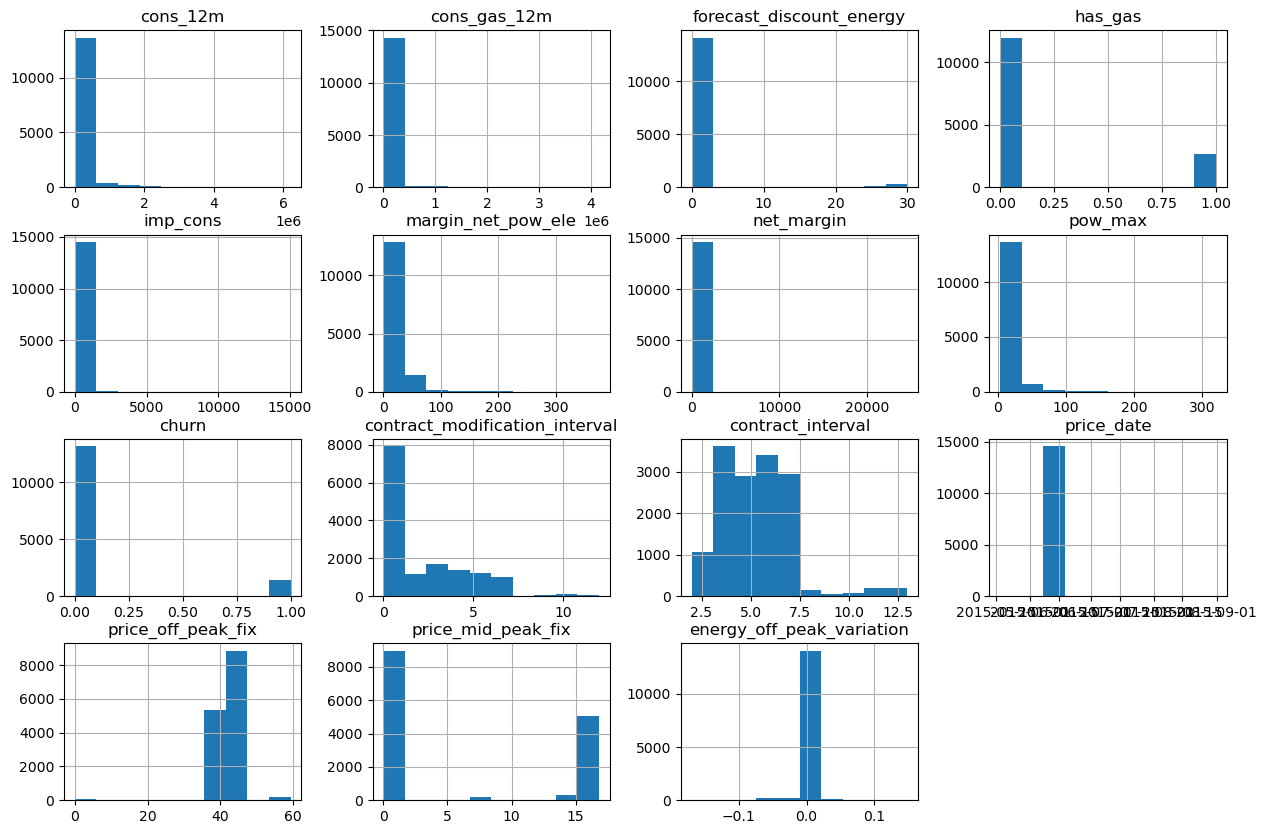

In [42]:
#Univariant Analysis
df.hist(figsize=(15,10))
plt.show()

From the histograms, we can say that there is outliers and skewness in the continuous value features needed

In [43]:
df.columns

Index(['channel_sales', 'cons_12m', 'cons_gas_12m', 'forecast_discount_energy',
       'has_gas', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 'origin_up',
       'pow_max', 'churn', 'contract_modification_interval',
       'contract_interval', 'price_date', 'price_off_peak_fix',
       'price_mid_peak_fix', 'energy_off_peak_variation'],
      dtype='object')

In [44]:
for col in ['cons_12m','cons_gas_12m', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 
       'pow_max',  'price_mid_peak_fix','energy_off_peak_variation','price_off_peak_fix']:
    df = outlier_removal(df,col,0.08)
    print(df.churn.value_counts())

Total No of rows in actual dataframe:  14593 
Total No of rows in outliers:  2084
churn
0    13174
1     1419
Name: count, dtype: int64
Total No of rows in actual dataframe:  14593 
Total No of rows in outliers:  2610
churn
0    13174
1     1419
Name: count, dtype: int64
Total No of rows in actual dataframe:  14593 
Total No of rows in outliers:  1214
churn
0    13174
1     1419
Name: count, dtype: int64
Total No of rows in actual dataframe:  14593 
Total No of rows in outliers:  660
churn
0    12635
1     1298
Name: count, dtype: int64
Total No of rows in actual dataframe:  13933 
Total No of rows in outliers:  979
churn
0    11764
1     1190
Name: count, dtype: int64
Total No of rows in actual dataframe:  12954 
Total No of rows in outliers:  1190
churn
0    11764
1     1190
Name: count, dtype: int64
Total No of rows in actual dataframe:  12954 
Total No of rows in outliers:  0
churn
0    11764
1     1190
Name: count, dtype: int64
Total No of rows in actual dataframe:  12954 
Total N

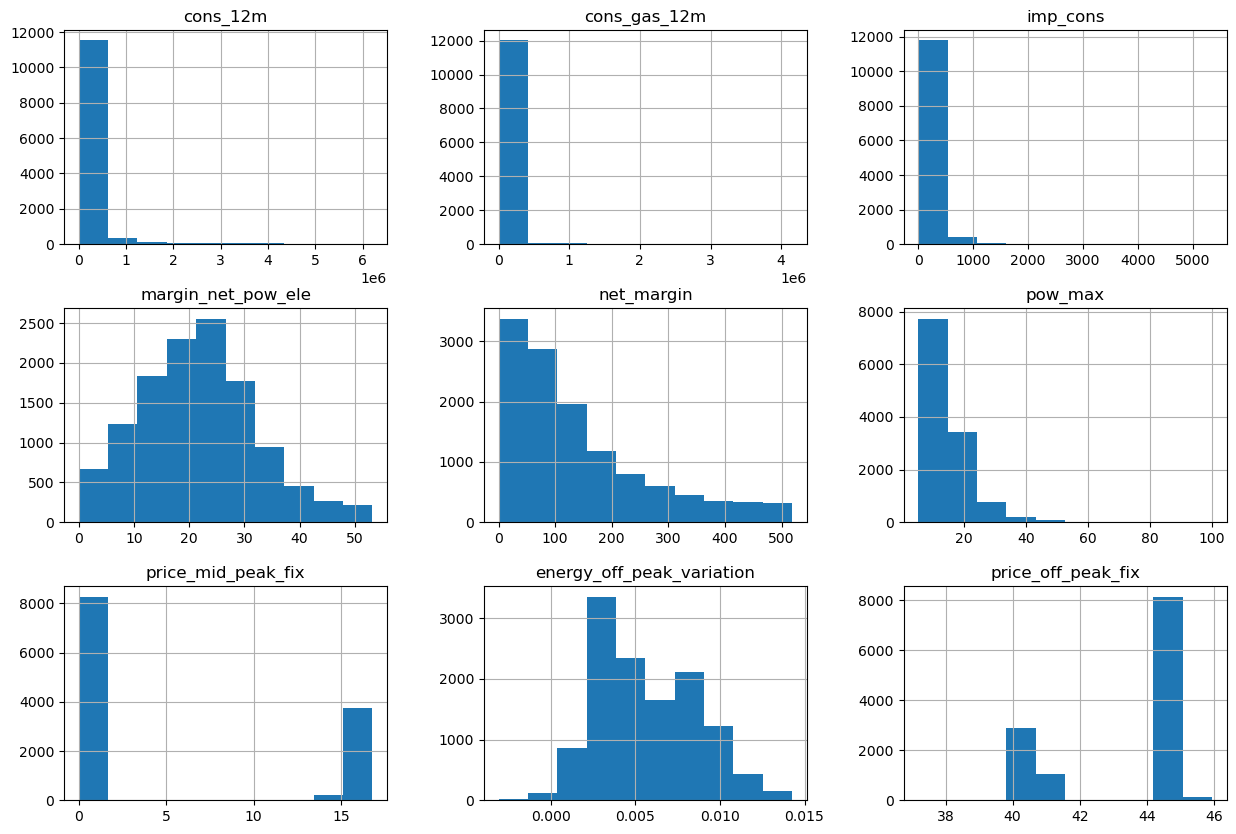

In [45]:
ax = df.hist(figsize=(15,10),column=['cons_12m', 'cons_gas_12m', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 
       'pow_max',  'price_mid_peak_fix','energy_off_peak_variation','price_off_peak_fix'],bins=10)
plt.show()

## Feature Analysis & Visualizations

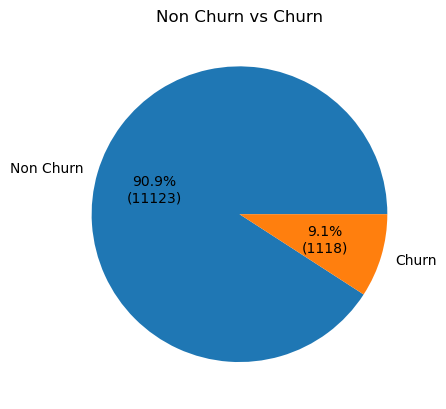

In [46]:
plt.pie(df.churn.value_counts(),
        labels=['Non Churn','Churn'],
        autopct=lambda x :annotation_labeling(x,df.churn.value_counts().values))
plt.title('Non Churn vs Churn')
plt.show()

In [47]:
#Splitting the dataset into churn and non-churn price by price date
churn_df = df[df['churn']==1]
non_churn_df = df[df['churn']==0]

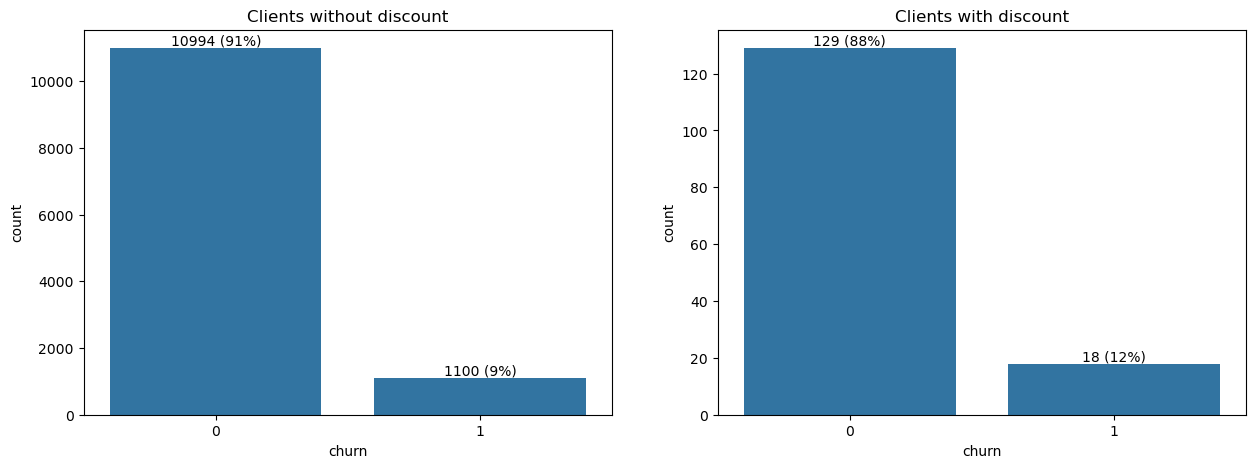

In [48]:
#Discount
abs_values_d = df[df.forecast_discount_energy != 0].churn.value_counts(ascending=False)
rel_values_d = df[df.forecast_discount_energy != 0].churn.value_counts(ascending=False, normalize=True).values * 100
dlbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values_d, rel_values_d)]

abs_values_wd = df[df.forecast_discount_energy == 0].churn.value_counts(ascending=False)
rel_values_wd = df[df.forecast_discount_energy == 0].churn.value_counts(ascending=False, normalize=True).values * 100
wdlbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values_wd, rel_values_wd)]

plt.figure(figsize=(15,5))
plt.subplot(121)
ax1 = sns.countplot(x='churn',data =df[df["forecast_discount_energy"]==0])
ax1.bar_label(container=ax1.containers[0], labels=wdlbls)
plt.title('Clients without discount')
plt.subplot(122)
ax2 = sns.countplot(x='churn',data =df[df["forecast_discount_energy"]!=0])
ax2.bar_label(container=ax2.containers[0], labels=dlbls)
plt.title('Clients with discount')
plt.suptitle('')
plt.show()

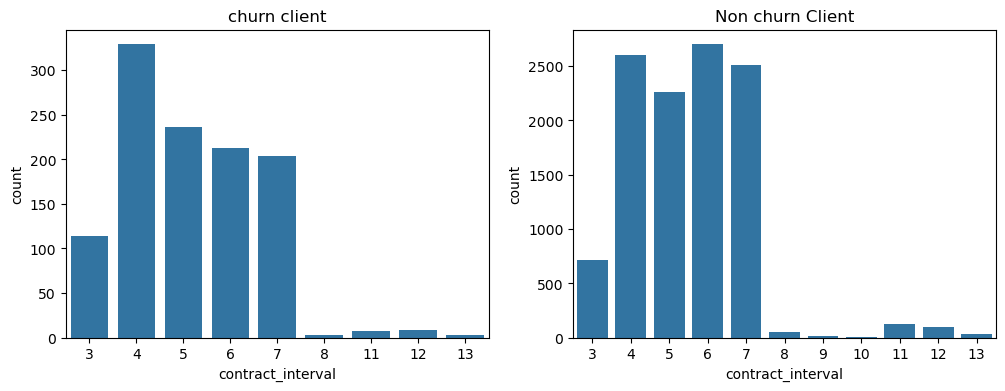

In [49]:
#Contract Interval
plt.figure(figsize=(12,4))
plt.subplot(121)
ax1 = sns.countplot(x="contract_interval",data = churn_df)
plt.title("churn client")
plt.subplot(122)
ax2 = sns.countplot(x="contract_interval",data=non_churn_df)
plt.title("Non churn Client")
plt.show()

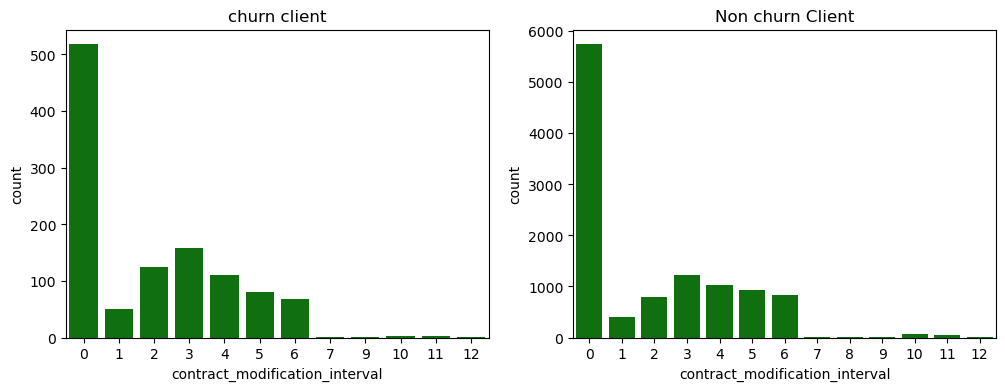

In [50]:
#Contract Modification
plt.figure(figsize=(12,4))
plt.subplot(121)
ax1 = sns.countplot(x="contract_modification_interval",data = churn_df,palette=['g'])
plt.title("churn client")
plt.subplot(122)
ax2 = sns.countplot(x="contract_modification_interval",data=non_churn_df,palette=['g'])
plt.title("Non churn Client")
plt.show()

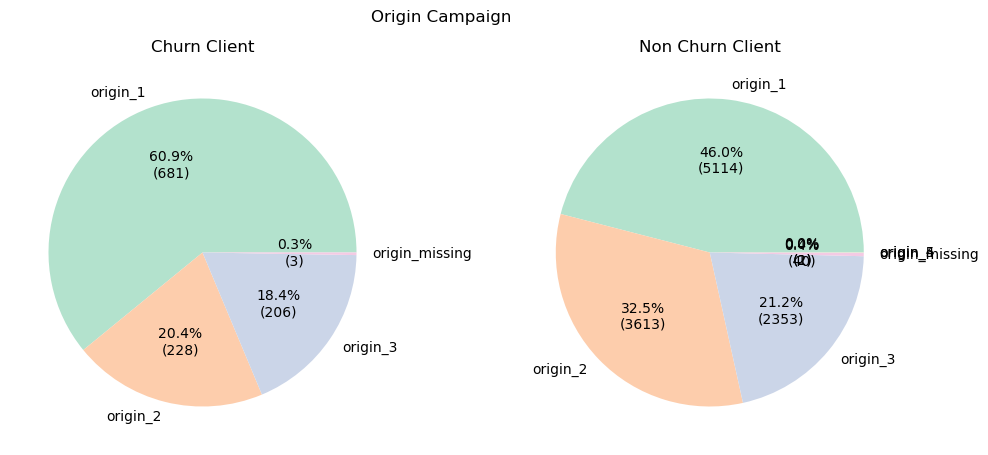

In [51]:
#Origin Campaign

plt.figure(figsize=(12,5))
plt.subplot(121)
ax1 = plt.pie(churn_df.origin_up.value_counts(),
              labels=churn_df.origin_up.value_counts().index,
              autopct=lambda x :annotation_labeling(x,churn_df.origin_up.value_counts().values),
              colors=plt.cm.Pastel2.colors)
plt.title("Churn Client")
plt.subplot(122)
ax1 = plt.pie(non_churn_df.origin_up.value_counts(),
              labels=non_churn_df.origin_up.value_counts().index,
              autopct=lambda x :annotation_labeling(x,non_churn_df.origin_up.value_counts().values),
              colors=plt.cm.Pastel2.colors)
plt.title("Non Churn Client")
plt.suptitle("Origin Campaign")
plt.show()

Sales Channel

In [52]:
clients_channel_count = df['channel_sales'].value_counts()
data = {
    'Channel Name' : clients_channel_count.index.values,
    'Channel Count' : clients_channel_count.values,
    'Percentage' : (clients_channel_count.values/client_data.shape[0])*100
}
channel_sales_data = pd.DataFrame(data)


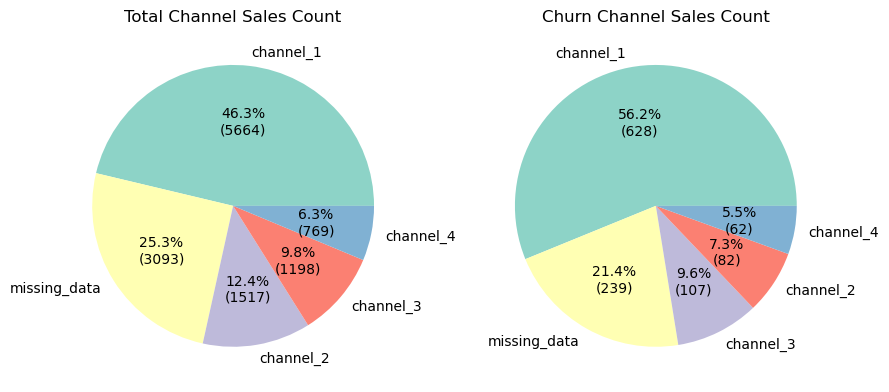

<Figure size 1000x500 with 0 Axes>

In [53]:
churn_channel_sales =churn_df['channel_sales'].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
plt.figure(figsize=(10,5))
#To avoid clumsiness in chart, last three rows are not taken into account for the plotting.
_,_,ax1_text = ax1.pie(x=channel_sales_data['Channel Count'][:-3],
                       labels=channel_sales_data['Channel Name'][:-3],
                       autopct = lambda x : annotation_labeling(x,channel_sales_data['Channel Count'].values),
                       colors=colors)
ax1.set_title('Total Channel Sales Count')
_,_,ax2_text=ax2.pie(x=churn_channel_sales.values,labels=churn_channel_sales.index,autopct = lambda x : annotation_labeling(x,churn_channel_sales.values),colors=colors)
ax2.set_title('Churn Channel Sales Count')

plt.show()

Nearly 10% of the client left the company in 2015. There is a change in price scale between churn and non-churn clients. Most of the churned custtomers are from the sales channel and origin, so a detailed analysis of that particular part can give more information on factors affecting customer churn rate. Recent customers are more likely to leave the company, the possible reasons can be low competitor's prices or poor customer care

## Dimensionality Reduction

Before getting into the modelling part, visualizing the orientation of the data can give insights into selecting suitable model for training. Since there were many variables, we can use dimensionality reduction to visualize the data

In [62]:
df = pd.get_dummies(df, drop_first=True)
x,y = df.drop(columns=['churn','price_date'],axis=1),df.churn

In [63]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(x)), columns=['PCA1','PCA2'])
pca_df['churn'] = df['churn']
pca_df.head()

,PCA1,PCA2,churn
0,-1.642506,-0.843874,NaN
1,-1.517882,-0.405826,0.0
2,-1.461919,0.646447,0.0
3,1.497983,-1.297063,0.0
4,-0.501526,-0.687993,0.0


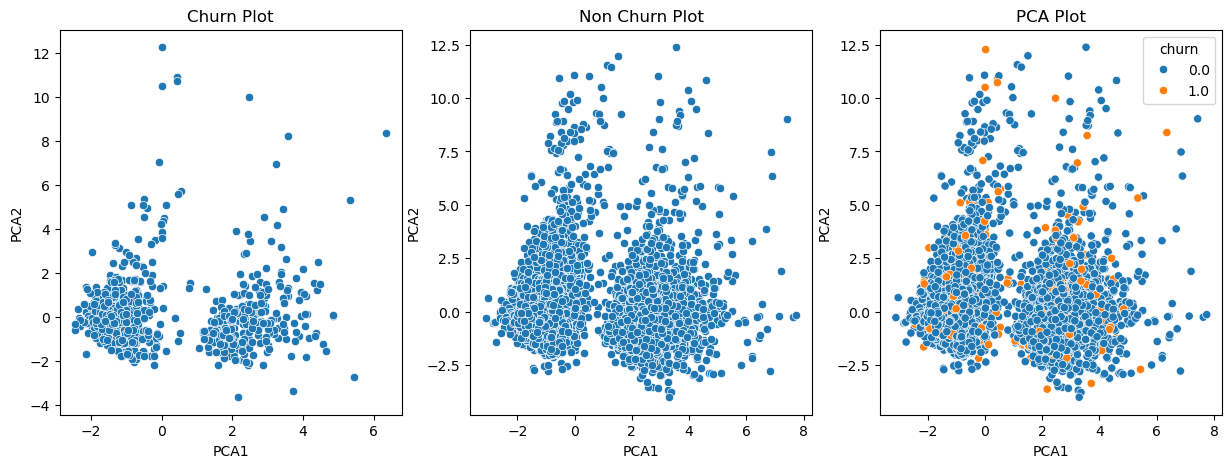

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.scatterplot(data=pca_df[pca_df['churn']==1],x='PCA1',y='PCA2')
plt.title('Churn Plot')
plt.subplot(132)
sns.scatterplot(data=pca_df[pca_df["churn"]==0],x='PCA1',y='PCA2')
plt.title('Non Churn Plot')
plt.subplot(133)
sns.scatterplot(data=pca_df,x='PCA1',y='PCA2',hue='churn')
plt.title('PCA Plot')
plt.show()

There are some extreme points that makes the plot skewed, lets remove those points to view more clearly

In [66]:
lb1, ub1 = iqr_range(pca_df['PCA1'])
pca_df.drop(pca_df[(pca_df['PCA1'] <lb1) | (pca_df['PCA1'] >ub1)].index,inplace=True)

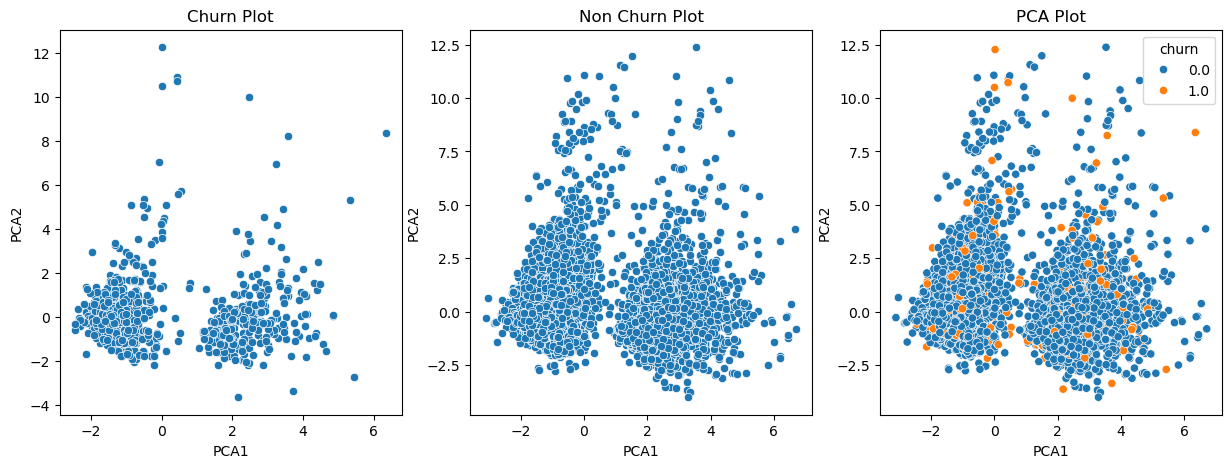

In [67]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.scatterplot(data=pca_df[pca_df['churn']==1],x='PCA1',y='PCA2')
plt.title('Churn Plot')
plt.subplot(132)
sns.scatterplot(data=pca_df[pca_df["churn"]==0],x='PCA1',y='PCA2')
plt.title('Non Churn Plot')
plt.subplot(133)
sns.scatterplot(data=pca_df,x='PCA1',y='PCA2',hue='churn')
plt.title('PCA Plot')
plt.show()

By seeing the PCA plot, we can see that both churn and non-churn customers were not well separated. In the case of predictive modeling, KNN doesn't help much. We didn't see any clear separation boundary or cluster. But there may be a separation in a higher dimension that can be addressed by a hyperplane. If there is no effective hyperplane exists, we can try Tree and Ensemble Based Algorithms. Before getting our hands on predictive modeling, we need to clear the imbalances in the dataset. Let's use the decision tree to choose the correct sample strategy.

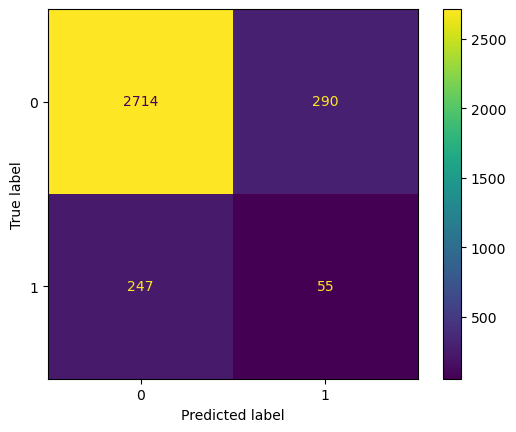

Model's f1 score for training dataset : 1.0 
Model's f1 score for test dataset : 0.17001545595054096
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3004
           1       0.16      0.18      0.17       302

    accuracy                           0.84      3306
   macro avg       0.54      0.54      0.54      3306
weighted avg       0.85      0.84      0.84      3306



In [68]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.27,stratify=y,random_state=42)
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_train_pred = dt_model.predict(x_train)
y_pred = dt_model.predict(x_test)

cm_pred2 = confusion_matrix(y_test,y_pred,labels = dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,y_train_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

### Handling Imbalanceness of the data
**Determining Sampling Strategies for over-sampling the minority class**


In [69]:
#Balancing the dataset by using simple oversample follow by undersampling
oversample = RandomOverSampler(sampling_strategy=0.5)
undersample = RandomUnderSampler(sampling_strategy='majority')

x_s,y_s = oversample.fit_resample(x,y)
x_s,y_s = undersample.fit_resample(x_s,y_s)

x_train,x_test,y_train,y_test = train_test_split(x_s,y_s,test_size=0.27,stratify=y_s,random_state=42)

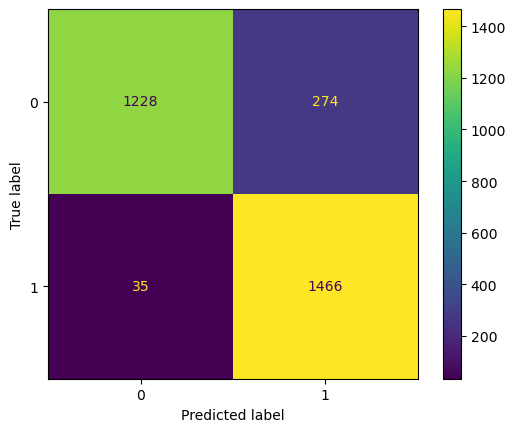

Model's f1 score for training dataset : 1.0 
Model's f1 score for test dataset : 0.9046590558469608
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1502
           1       0.84      0.98      0.90      1501

    accuracy                           0.90      3003
   macro avg       0.91      0.90      0.90      3003
weighted avg       0.91      0.90      0.90      3003



In [70]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

y_train_pred = dt_model.predict(x_train)
y_pred = dt_model.predict(x_test)

cm_pred2 = confusion_matrix(y_test,y_pred,labels=dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :", f1_score(y_train,y_train_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))

print(classification_report(y_test,y_pred))

In [71]:
#Feature importance as per the model with combined oversampling and undersampling
pd.Series(dt_model.feature_importances_,x_s.columns).sort_values(ascending=False)


cons_12m                          0.163797
margin_net_pow_ele                0.144036
net_margin                        0.132680
energy_off_peak_variation         0.111435
imp_cons                          0.091192
pow_max                           0.086889
price_off_peak_fix                0.056877
contract_modification_interval    0.038293
contract_interval                 0.037398
cons_gas_12m                      0.029645
origin_up_origin_2                0.023407
price_mid_peak_fix                0.020701
channel_sales_channel_3           0.019436
channel_sales_missing_data        0.014178
origin_up_origin_3                0.011393
channel_sales_channel_2           0.006956
channel_sales_channel_4           0.006013
has_gas                           0.003360
origin_up_origin_missing          0.001287
forecast_discount_energy          0.001026
channel_sales_channel_5           0.000000
channel_sales_channel_6           0.000000
channel_sales_channel_7           0.000000
origin_up_o

In [72]:
# Balancing dataset using Synthetic Minority Over-sampling Technique with Edited Nearest Neighbour
smt = SMOTEENN(random_state=42,sampling_strategy=0.7)
x_s,y_s = smt.fit_resample(x,y)
x_train,x_test,y_train,y_test = train_test_split(x_s,y_s,test_size=0.27,stratify=y_s,random_state=42)


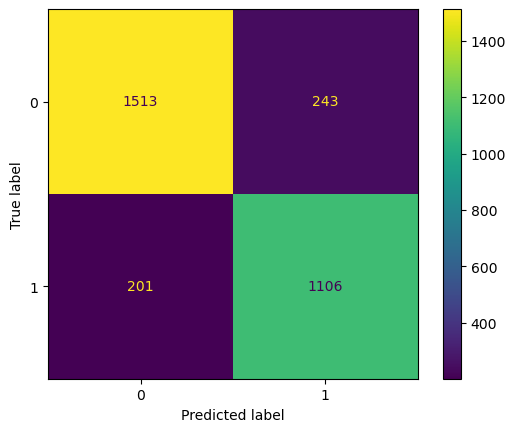

Model's f1 score for training dataset : 1.0 
Model's f1 score for test dataset : 0.8328313253012049
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1756
           1       0.82      0.85      0.83      1307

    accuracy                           0.86      3063
   macro avg       0.85      0.85      0.85      3063
weighted avg       0.86      0.86      0.86      3063



In [73]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_train_pred = dt_model.predict(x_train)
y_pred = dt_model.predict(x_test)

cm_pred2 = confusion_matrix(y_test,y_pred,labels = dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,y_train_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [74]:
#Feature importance as per the model with SMOTEENN
pd.Series(dt_model.feature_importances_,x_s.columns).sort_values(ascending=False)

price_mid_peak_fix                0.259851
cons_12m                          0.133003
pow_max                           0.093111
price_off_peak_fix                0.087957
margin_net_pow_ele                0.086634
net_margin                        0.076238
energy_off_peak_variation         0.074010
imp_cons                          0.046674
contract_interval                 0.034433
channel_sales_missing_data        0.028981
contract_modification_interval    0.021453
origin_up_origin_2                0.015970
cons_gas_12m                      0.014507
origin_up_origin_3                0.007039
has_gas                           0.006517
channel_sales_channel_3           0.005269
channel_sales_channel_4           0.002720
channel_sales_channel_2           0.002158
forecast_discount_energy          0.002132
origin_up_origin_missing          0.001343
channel_sales_channel_7           0.000000
channel_sales_channel_6           0.000000
origin_up_origin_4                0.000000
origin_up_o

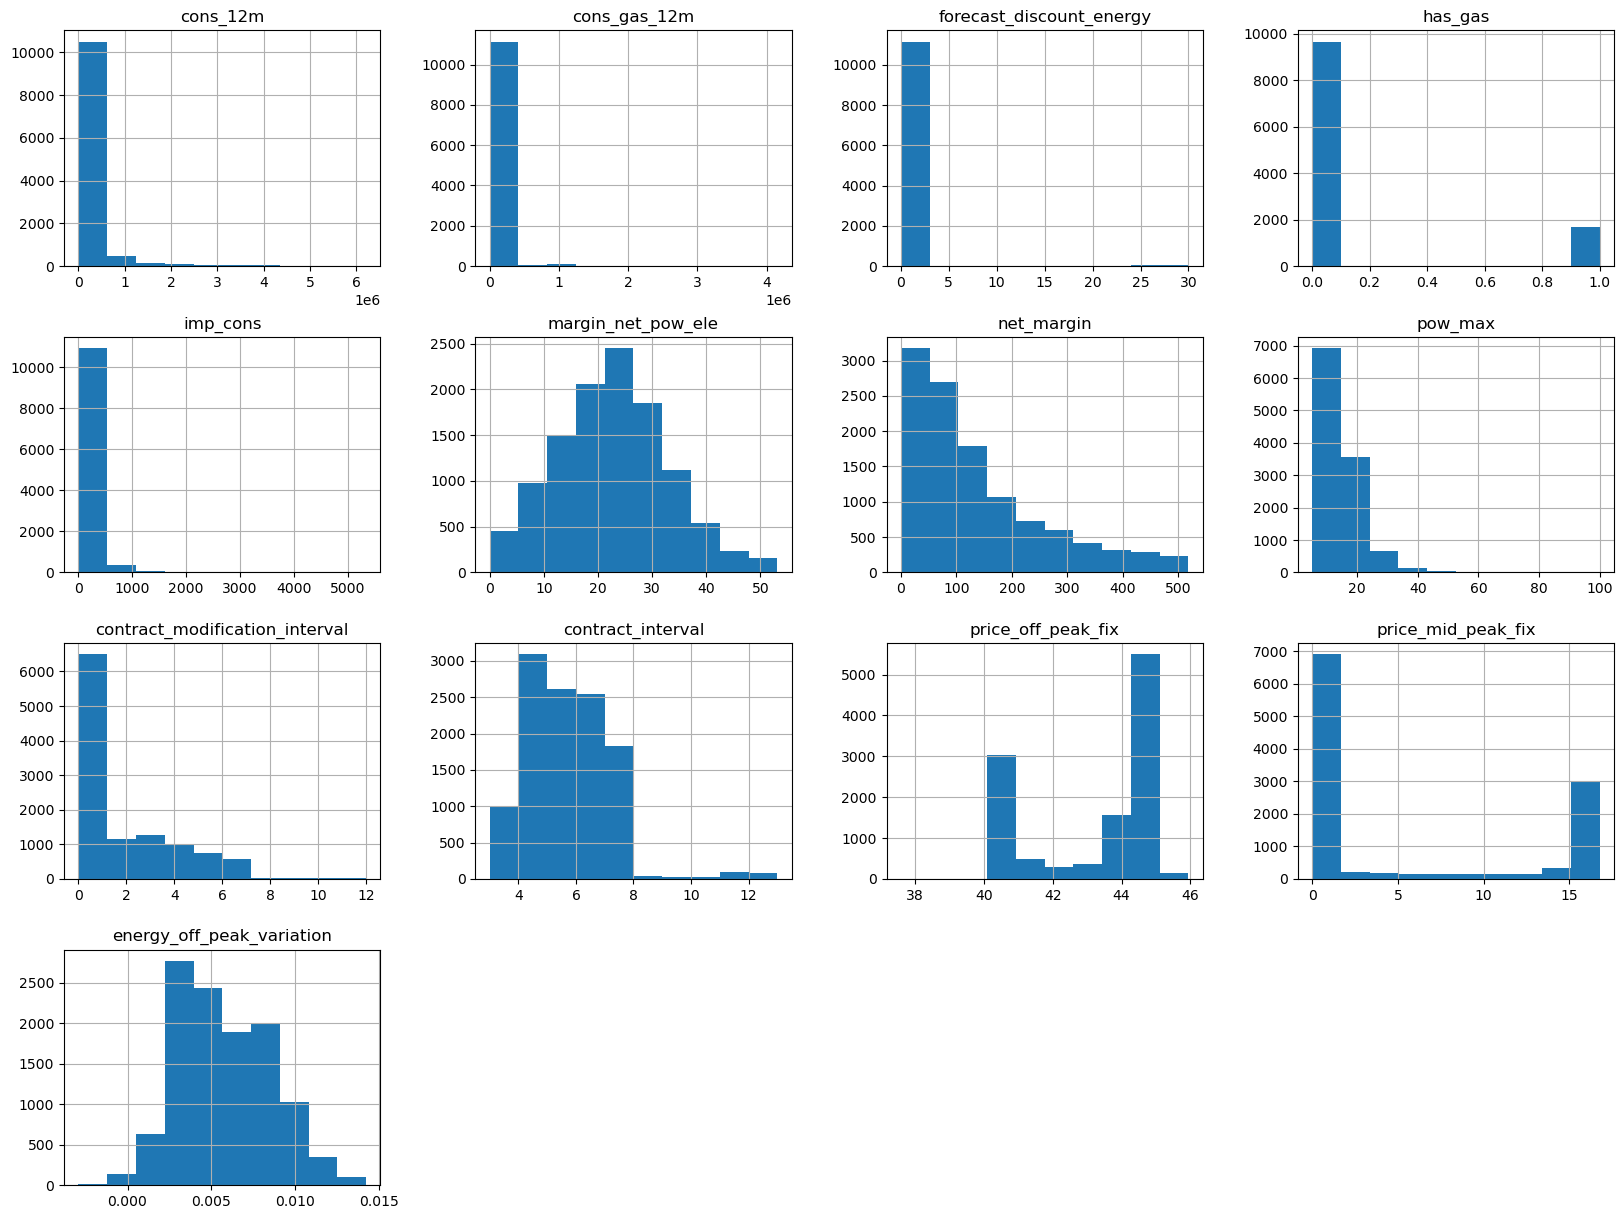

In [75]:
x_s.hist(figsize=(20,15))
plt.show()

The synthesized samples by SMOTEENN had a significant impact on feature importance. A discussion with domain expert is needed to verify such values and distributions in the features is possible or not. For this analysis, we use combined undersampling and oversampling as our sampling technique.

## Combined Over-Sampling and Under-Sampling

In [76]:
oversample = RandomOverSampler(sampling_strategy=0.5)
undersample = RandomUnderSampler(sampling_strategy='majority')
x_s,y_s = oversample.fit_resample(x,y)
x_s,y_s = undersample.fit_resample(x_s,y_s)
x_train,x_test,y_train,y_test = train_test_split(x_s,y_s,test_size=0.27,stratify=y_s,random_state=42)

## Model Creation

### Logistic Regression

In the EDA part itself, we have seen that the data were highly skewed, so before applying logistic regression necessary feature transformation is needed for better performance

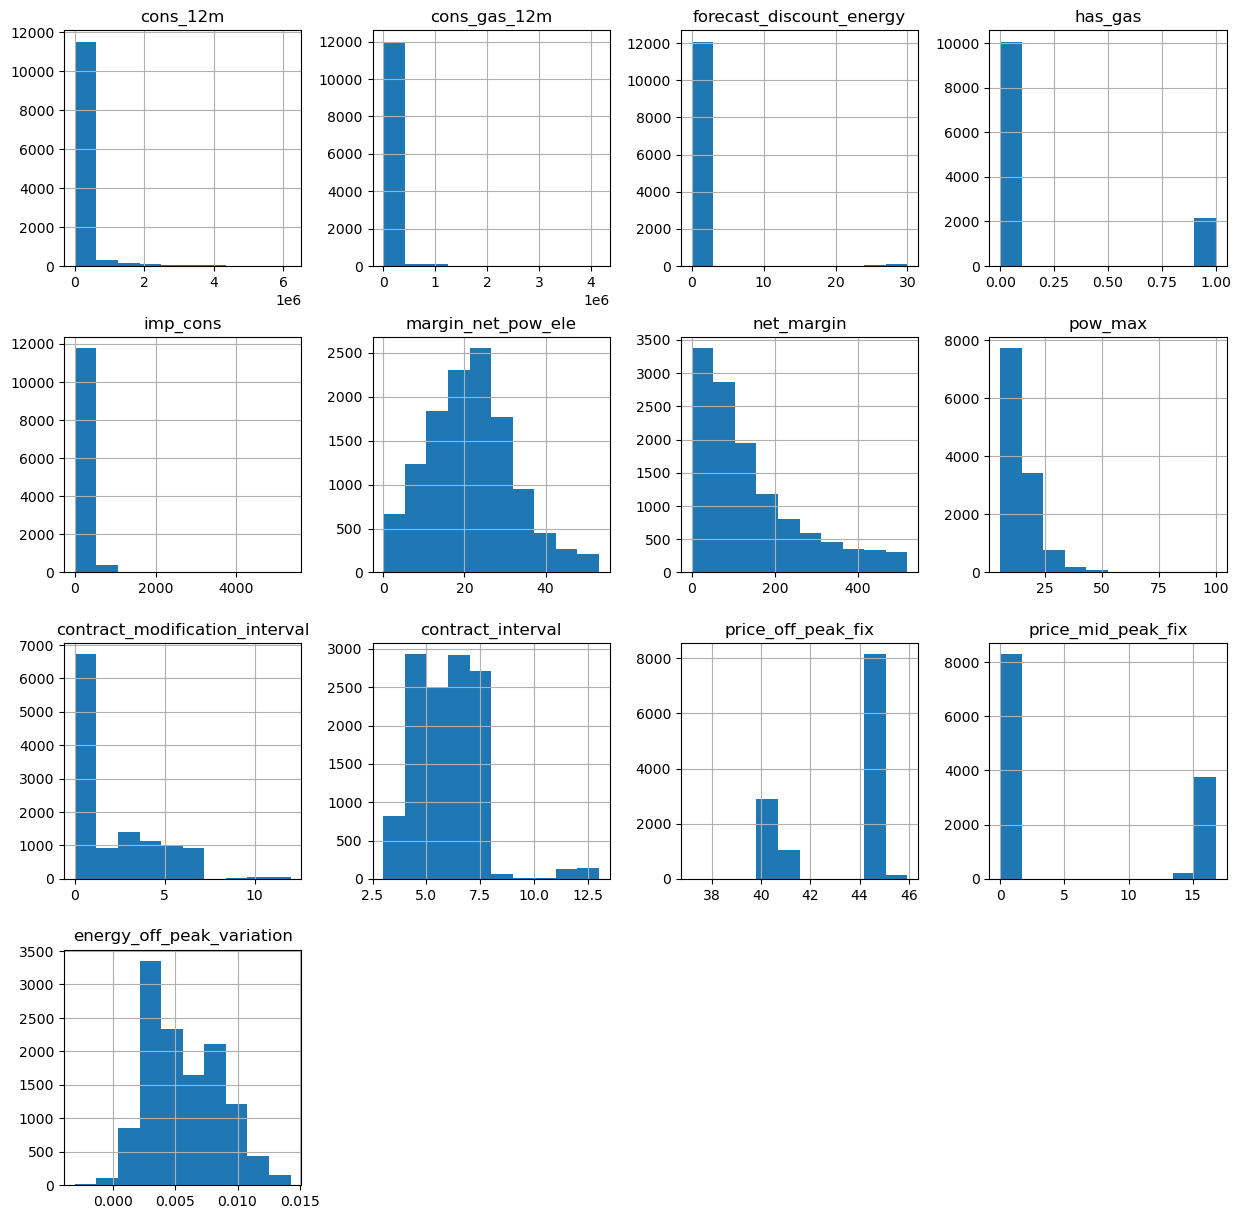

In [77]:
#Distribution of features before transformation
x.hist(figsize=(15,15),bins=10)
plt.show()

In [78]:
x_scaled = pd.DataFrame(MinMaxScaler().fit_transform(x),columns=x.columns)
q_trans = QuantileTransformer(output_distribution="normal")
x_scaled['cons_12m'] = q_trans.fit_transform(x_scaled['cons_12m'].values.reshape(-1, 1))
x_scaled['net_margin'] = q_trans.fit_transform(x_scaled['net_margin'].values.reshape(-1, 1))
x_scaled['pow_max'] = q_trans.fit_transform(x_scaled['pow_max'].values.reshape(-1, 1))
x_scaled['contract_modification_interval'] = q_trans.fit_transform(x_scaled['contract_modification_interval'].values.reshape(-1, 1))
x_scaled['contract_interval'] = q_trans.fit_transform(x_scaled['contract_interval'].values.reshape(-1, 1))
x_scaled['price_off_peak_fix'] = q_trans.fit_transform(x_scaled['price_off_peak_fix'].values.reshape(-1, 1))
x_scaled['price_mid_peak_fix'] = q_trans.fit_transform(x_scaled['price_mid_peak_fix'].values.reshape(-1, 1))
x_scaled['energy_off_peak_variation'] = q_trans.fit_transform(x_scaled['energy_off_peak_variation'].values.reshape(-1, 1))
x_scaled['cons_gas_12m'] = q_trans.fit_transform(x_scaled['cons_gas_12m'].values.reshape(-1, 1))
x_scaled['imp_cons'] = q_trans.fit_transform(x_scaled['cons_gas_12m'].values.reshape(-1, 1))

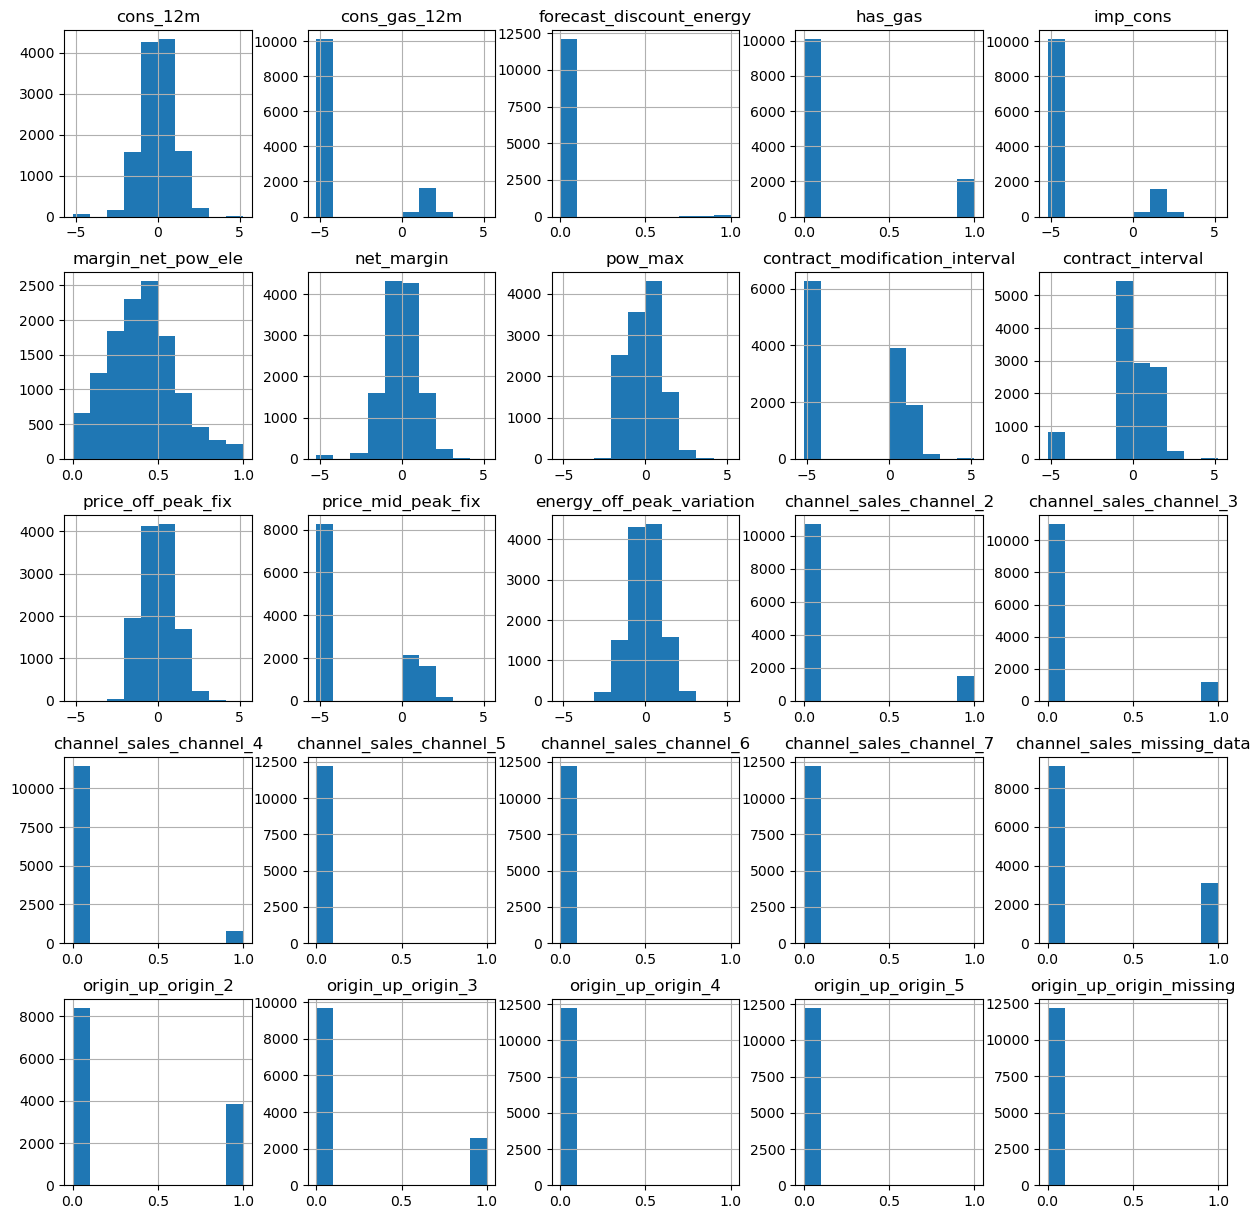

In [80]:
#Distribution of features after transformation
x_scaled.hist(figsize=(15,15),bins=10)
plt.show()

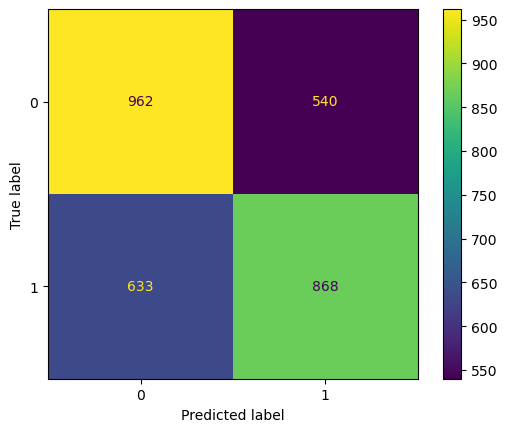

Model's f1 score for training dataset : 0.5890900135451299 
Model's f1 score for test dataset : 0.5967686490202819
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      1502
           1       0.62      0.58      0.60      1501

    accuracy                           0.61      3003
   macro avg       0.61      0.61      0.61      3003
weighted avg       0.61      0.61      0.61      3003



In [81]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(x_train,y_train)
yt_pred = log_reg.predict(x_train)
y_pred = log_reg.predict(x_test)
cm_pred2 = confusion_matrix(y_test,y_pred,labels = dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,yt_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))


### Support Vector Classification

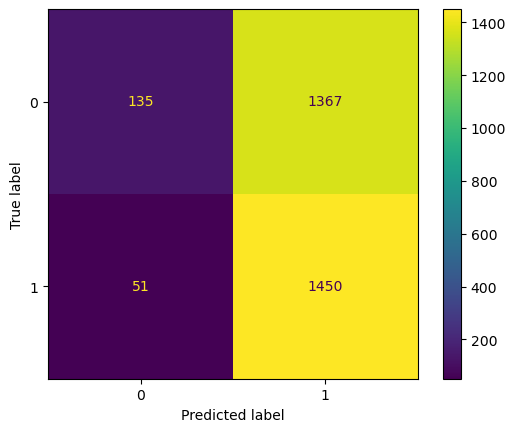

Model's f1 score for training dataset : 0.6704486848891181 
Model's f1 score for test dataset : 0.6716072255673923
              precision    recall  f1-score   support

           0       0.73      0.09      0.16      1502
           1       0.51      0.97      0.67      1501

    accuracy                           0.53      3003
   macro avg       0.62      0.53      0.42      3003
weighted avg       0.62      0.53      0.42      3003



In [82]:
svc_model = SVC(random_state=0)
svc_model.fit(x_train,y_train)
yt_pred = svc_model.predict(x_train)
y_pred = svc_model.predict(x_test)
cm_pred2 = confusion_matrix(y_test,y_pred,labels = svc_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=svc_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,yt_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

From the results of Logistic Regression and Support Vector Classifier, we can conclude that there is no hyperplane that effectively separate the churn and unchurned customers. Let's try with Decision Tree and Ramdom Forest.

### Decision Tree

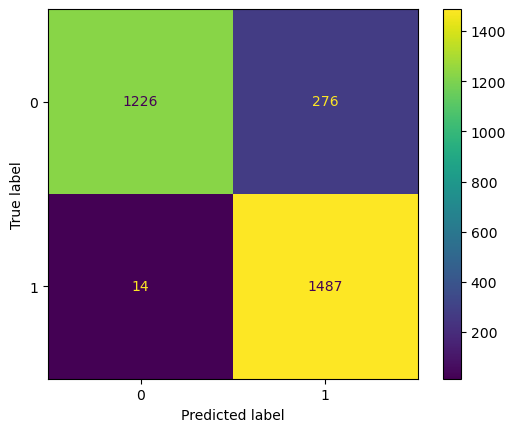

Model's f1 score for training dataset : 1.0 
Model's f1 score for test dataset : 0.9111519607843137
              precision    recall  f1-score   support

           0       0.99      0.82      0.89      1502
           1       0.84      0.99      0.91      1501

    accuracy                           0.90      3003
   macro avg       0.92      0.90      0.90      3003
weighted avg       0.92      0.90      0.90      3003



In [83]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_train_pred = dt_model.predict(x_train)
y_pred = dt_model.predict(x_test)

cm_pred2 = confusion_matrix(y_test,y_pred,labels = dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,y_train_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))


### Random Forest

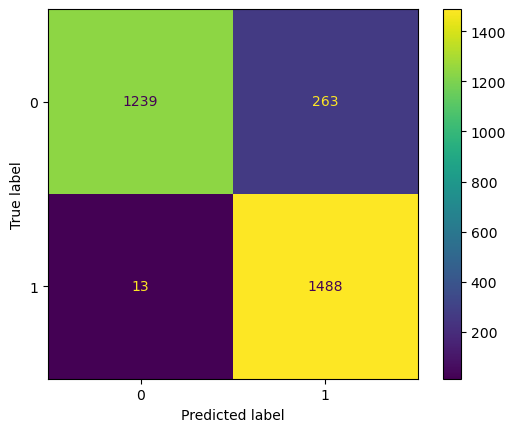

Model's f1 score for training dataset : 1.0 
Model's f1 score for test dataset : 0.915129151291513
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1502
           1       0.85      0.99      0.92      1501

    accuracy                           0.91      3003
   macro avg       0.92      0.91      0.91      3003
weighted avg       0.92      0.91      0.91      3003



In [84]:
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_train_pred = dt_model.predict(x_train)
y_pred = dt_model.predict(x_test)

cm_pred2 = confusion_matrix(y_test,y_pred,labels = dt_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_pred2,display_labels=dt_model.classes_).plot()
plt.show()

print("Model's f1 score for training dataset :",f1_score(y_train,y_train_pred),
      "\nModel's f1 score for test dataset :",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))


**From the above classifiers, we can say that the random forest model did the best job of separating churn and non-churn customers. The selection of sampling technique plays a major role here, because the price variation has variable impact based on sampling strategy. But as per the model energy consumption, profit margin, subscribed power, etc has significant importance in the classification task. So we need to investigate the price technique, competitor's subscription plans and discount to arrive precise conclusion.**